# MULTIPLE INSTANCE LEARNING (MIL)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
col_names = ["is_musk", "bag_id"] + [f"F{i}" for i in range(166)]
data = pd.read_csv("./Musk1.csv", names=col_names)
print(data.shape)
data.head()

(476, 168)


,is_musk,bag_id,F0,F1,F2,F3,F4,F5,F6,F7,...,F156,F157,F158,F159,F160,F161,F162,F163,F164,F165
0,1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
2,1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
3,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
4,1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26


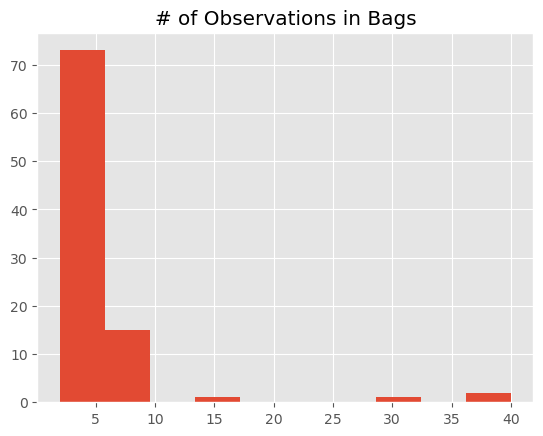

In [3]:
data.bag_id.value_counts().hist()
plt.title("# of Observations in Bags")
plt.show()

In [4]:
data.bag_id.value_counts().describe()

count    92.000000
mean      5.173913
std       6.432419
min       2.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      40.000000
Name: bag_id, dtype: float64

The # of observation in each bag is not the same therefore we cannot simply represent it in a wide manner where the data has 166*(N observation in a bag). We need to figure out another way to do it. As the instructions say one option is to use the mean as the bag level representation. We will use the mean representation as the baseline features and evaluate its performance in every algorithm.

In [5]:
mean_data = data.groupby("bag_id").mean().reset_index()
mean_data.head()

,bag_id,is_musk,F0,F1,F2,F3,F4,F5,F6,F7,...,F156,F157,F158,F159,F160,F161,F162,F163,F164,F165
0,1,1.0,42.000000,-194.500000,-125.750000,-70.000000,-117.0,33.000000,36.000000,-128.5,...,-238.000000,-187.75,-34.0,-120.000000,-38.500000,30.250000,48.000000,-37.000000,5.500000,30.250000
1,2,1.0,42.000000,-194.500000,-122.000000,-70.000000,-117.0,33.000000,36.250000,-128.0,...,-238.000000,-186.25,-32.5,51.000000,126.500000,143.500000,42.750000,-30.250000,14.000000,26.500000
2,3,1.0,42.000000,-166.000000,-102.500000,-30.500000,-116.5,5.000000,27.500000,-142.5,...,-235.500000,-57.50,-45.5,13.000000,120.500000,133.500000,55.500000,-32.500000,2.000000,16.500000
3,4,1.0,42.666667,-154.666667,-77.333333,-42.333333,-117.0,22.333333,21.666667,-132.0,...,-237.333333,-142.00,-15.0,-80.333333,-33.666667,31.333333,50.333333,-38.333333,5.333333,32.333333
4,5,1.0,61.500000,-72.500000,-102.000000,-25.250000,-34.0,19.000000,29.000000,-143.5,...,-237.750000,-117.25,-60.5,5.000000,75.750000,136.750000,68.500000,-26.750000,-0.250000,36.750000


## Using Distribution Information

Constructing the representations using the feature distributions in the bag makes sense. One way to embed the distribution in our features is using the min max valeus in the bag additional to the mean. Also, I think that # of observations in each bag can be a usefull feature especially if we use a tree based algorithm.

In [6]:
min_data = data.drop(columns="is_musk").groupby("bag_id").min().reset_index()
min_data.columns = [x+"_MIN" if x.startswith("F") else x for x in min_data]

max_data = data.drop(columns="is_musk").groupby("bag_id").max().reset_index()
max_data.columns = [x+"_MAX" if x.startswith("F") else x for x in max_data]

n_observations = data.groupby("bag_id").size().reset_index().rename(columns={0:"N"})

min_max_mean_data = mean_data.merge(min_data).merge(max_data).merge(n_observations)
print("New Data Shape: ", min_max_mean_data.shape)

New Data Shape:  (92, 501)


One imporovement to this method is to enhance the distribution information adding the missing quartiles. With these values we aim to represent the distribution in our features better.

In [7]:
q25_data = data.drop(columns="is_musk").groupby("bag_id").quantile(0.25).reset_index()
q25_data.columns = [x+"_Q25" if x.startswith("F") else x for x in q25_data]

q75_data = data.drop(columns="is_musk").groupby("bag_id").max().reset_index()
q75_data.columns = [x+"_Q75" if x.startswith("F") else x for x in q75_data]

dist_data = min_max_mean_data.merge(q25_data).merge(q75_data)

# std_data = data.drop(columns="is_musk").groupby("bag_id").std().reset_index()
# std_data.columns = [x+"_STD" if x.startswith("F") else x for x in std_data]
# dist_data = min_max_mean_data.merge(std_data)

print("New Data Shape: ", dist_data.shape)

New Data Shape:  (92, 833)


# Random Forest Classifier

In [8]:
param_grid = {
    'min_samples_leaf': [1, 3, 7],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 250, 500, 750],
    "random_state":[3136],
    "n_jobs":[-1]
}

In [9]:
results = []

names = ["Mean Data", "Min Max Mean Data", "Dist Data"]
X_vals = [
    mean_data.drop(columns=["bag_id", "is_musk"]),
    min_max_mean_data.drop(columns=["bag_id", "is_musk"]),
    dist_data.drop(columns=["bag_id", "is_musk"]),
]
y_vals = [mean_data.is_musk, min_max_mean_data.is_musk, dist_data.is_musk]

rf_classifier = RandomForestClassifier()

# We need to tune the classifier in this step
# If I left a validation set separetely my predictions will be biased in that part of the train data
# Therefore I pass will do a grid search in each cross validation step. With 3 cv it shouldn't take much time
# Since we got a small amount of data
grid_searher = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1)

for X, y, name in zip(X_vals, y_vals, names):

    cvs = cross_val_score(
        estimator=grid_searher, 
        X=X, 
        y=y, 
        scoring="accuracy", 
        cv=10
    )

    line = ["RF", name, cvs.mean()]
    results.append(line)
    print(line)


['RF', 'Mean Data', 0.8344444444444445]
['RF', 'Min Max Mean Data', 0.8566666666666667]
['RF', 'Dist Data', 0.8244444444444445]


## Logistic Regression

In [10]:
logreg_none = LogisticRegression(penalty="none", max_iter=1000)

for X, y, name in zip(X_vals, y_vals, names):

    cvs = cross_val_score(
        estimator=logreg_none, 
        X=X, 
        y=y, 
        scoring="accuracy", 
        cv=10
    )

    line = ["Log Reg", name, cvs.mean()]
    results.append(line)
    print(line)

# Add l2  penalty. It will tune the parameter using cross validation
logreg_l2 = LogisticRegressionCV(penalty="l2", max_iter=1000)
for X, y, name in zip(X_vals, y_vals, names):

    cvs = cross_val_score(
        estimator=logreg_l2, 
        X=X, 
        y=y, 
        scoring="accuracy", 
        cv=10
    )

    line = ["Log Reg l2", name, cvs.mean()]
    results.append(line)
    print(line)


['Log Reg', 'Mean Data', 0.8588888888888888]
['Log Reg', 'Min Max Mean Data', 0.8688888888888888]
['Log Reg', 'Dist Data', 0.8577777777777778]
['Log Reg l2', 'Mean Data', 0.8477777777777777]


/home/harunkivril/anaconda3/envs/forelux_torch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['Log Reg l2', 'Min Max Mean Data', 0.9111111111111111]
['Log Reg l2', 'Dist Data', 0.9111111111111111]


Convergence warning seems like a not a problem here since it performs well in cross validation.

In [11]:
results = pd.DataFrame(results, columns=["Method" , "Features", "Accuracy"])
results = results.pivot(index="Method", columns="Features", values="Accuracy")
results

Features,Dist Data,Mean Data,Min Max Mean Data
Method,,,
Log Reg,0.857778,0.858889,0.868889
Log Reg l2,0.911111,0.847778,0.911111
RF,0.824444,0.834444,0.856667


It appears that the best result comes from the l2 regularized Dist data and Min Max Mean Data. It appears that the missing quartiles does not add much information, it can be beacuse of the bags with a little instances which has quartiles that makes no sense. Also, having a regularized method as best makes sense because the number of data points are less than the number of features and a complex model can easily overfit. Regularization helps to control overfitting and obtain beter results.

## Trying to Find the Most Usefull Observation

Another idea to determine the most usefull observation and use it as a bag representation. One way to do it is to use a distance metric to get the most distinct observatian from the mean of the data. This may help to select a proper observation in the bag and imporove the classification. This method can be improved by using an iterative approach to find the best representation however it would be a very detailed method that is out of scope of this task. Applying this method to the setting above would create bias since the distance should only be calculated in the training set. Therefore, we need to write cross validation steps on our own.

In [12]:
cv = KFold(n_splits=10, shuffle=True, random_state=3136)
bags = data.bag_id.unique()

rf_res = []
logreg_res = []
# We need to split bags not observations in this case
for train, test in cv.split(bags):
    train, test = bags[train], bags[test]
    train_data, test_data = data[data.bag_id.isin(train)].copy(), data[data.bag_id.isin(test)].copy()
    # Scale data to avoid feature scales effect the distances
    
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data.drop(columns=["bag_id", "is_musk"]))
    scaled_test_data = scaler.transform(test_data.drop(columns=["bag_id", "is_musk"]))
    
    # Classes are almost balanced how ever I believe getting mean class means is healtier
    representative_vec = (
        np.mean(scaled_train_data[train_data.is_musk], axis=0) 
        + np.mean(scaled_train_data[~train_data.is_musk], axis=0)
    )/2
    
    # Calculate distances to representative vector
    train_distances = np.sum(np.square(scaled_train_data - representative_vec), axis=1)
    train_data["dist"] = train_distances
    test_distances = np.sum(np.square(scaled_test_data - representative_vec), axis=1)
    test_data["dist"] = test_distances
    
    # Get the most distinct observation in bag 
    train_data = train_data.loc[train_data.groupby("bag_id").dist.idxmax()]
    test_data = test_data.loc[test_data.groupby("bag_id").dist.idxmax()]
    
    # Train RF with tuning & record accuracy
    grid_searher = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_searher.fit(train_data.drop(columns=["bag_id", "is_musk", "dist"]), train_data.is_musk)
    rf_preds = grid_searher.predict(test_data.drop(columns=["bag_id", "is_musk", "dist"]))
    rf_acc = (rf_preds == test_data.is_musk).sum()/test_data.shape[0]
    rf_res.append(rf_acc)
    
    # Train Log Reg and 
    logreg_classifier = LogisticRegressionCV(penalty="l2", max_iter=1000, solver="lbfgs")
    logreg_classifier.fit(train_data.drop(columns=["bag_id", "is_musk", "dist"]), train_data.is_musk)
    
    logreg_pred = logreg_classifier.predict(test_data.drop(columns=["bag_id", "is_musk", "dist"]))
    logreg_acc = (logreg_pred == test_data.is_musk).sum()/test_data.shape[0]
    logreg_res.append(logreg_acc)
    
    
print("RF Accuracy: ",np.mean(rf_res))
print("Log Reg Accuracy: ",np.mean(logreg_res))


RF Accuracy:  0.7811111111111111
Log Reg Accuracy:  0.8022222222222222


This method performs poor in terms of accuracy when it is compared to the distribution method. This result is reasanble since the method has some potential problems. First one is calculating the mean vector using the train data and we calculate a distance to a representation already includes that observation. This may cause a pottential overfitting. Secondly, just one of the instances in the bag may be causing a change in label and averaging may not make much sense. Additionaly label information can be hidden in multiple instances in the bag therefore by selecting just one we lost the information in other instances.

## Using distance to well known bags

When the instances in the bags are a lot it is hard to say that these instances represents the label, however there are bags with two observations. One of these observations or both together must carry information about the label, therefore we can say that these bags are well known. And the distances from observations from this bags to the other bags might be usefull. However, there is still variable number of observations in the other bags. This issue can be solved by using the minimum distance to the representative bag mean.

In [13]:
cv = KFold(n_splits=10, shuffle=True, random_state=3136)
bags = data.bag_id.unique()
train_cols = list(data.drop(columns=["bag_id", "is_musk"]))

rf_res = []
logreg_res = []
# We need to split bags not observations in this case
for train, test in cv.split(bags):
    train, test = bags[train], bags[test]
    train_data, test_data = data[data.bag_id.isin(train)].copy(), data[data.bag_id.isin(test)].copy()
    # Scale data to avoid feature scales effect the distances
    
    scaled_train_data = train_data[["bag_id", "is_musk"]].copy()
    scaled_test_data = test_data[["bag_id", "is_musk"]].copy()
    scaler = StandardScaler()
    scaled_train_data[train_cols] = scaler.fit_transform(train_data.drop(columns=["bag_id", "is_musk"]))
    scaled_test_data[train_cols] = scaler.transform(test_data.drop(columns=["bag_id", "is_musk"]))
    
    # Get well known bags in train data
    bag_sizes = scaled_train_data.groupby("bag_id").size()
    well_known_bags = bag_sizes[bag_sizes == 2].index
    print("# of Well Knowns in train_data: ", len(well_known_bags))
    # Get the mean of the observations and create well known bag representations
    well_known = (
        scaled_train_data[scaled_train_data.bag_id.isin(well_known_bags)]
    )
    
    train_dist_df = scaled_train_data[["bag_id", "is_musk"]].copy()
    test_dist_df = scaled_test_data[["bag_id", "is_musk"]].copy()
    well_known_bags = [f"BAGF_{i}" for i in range(len(well_known_bags)*2)]
    train_dist_df[well_known_bags] = euclidean_distances(scaled_train_data[train_cols], well_known[train_cols])
    test_dist_df[well_known_bags] = euclidean_distances(scaled_test_data[train_cols], well_known[train_cols])
    
    # Get the minimum distance to each well known
    train_dist_df = train_dist_df.groupby("bag_id").min().reset_index()
    test_dist_df = test_dist_df.groupby("bag_id").min().reset_index()
    
    
    # Train RF with tuning & record accuracy
    grid_searher = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_searher.fit(train_dist_df.drop(columns=["bag_id", "is_musk"]), train_dist_df.is_musk)
    rf_preds = grid_searher.predict(test_dist_df.drop(columns=["bag_id", "is_musk"]))
    rf_acc = (rf_preds == test_dist_df.is_musk).sum()/test_dist_df.shape[0]
    rf_res.append(rf_acc)
    
    # Train Log Reg and 
    logreg_classifier = LogisticRegressionCV(penalty="l2", max_iter=10000, solver="lbfgs")
    logreg_classifier.fit(train_dist_df.drop(columns=["bag_id", "is_musk"]), train_dist_df.is_musk)
    
    logreg_pred = logreg_classifier.predict(test_dist_df.drop(columns=["bag_id", "is_musk"]))
    logreg_acc = (logreg_pred == test_dist_df.is_musk).sum()/test_dist_df.shape[0]
    logreg_res.append(logreg_acc)
    
    
print("RF Accuracy: ",np.mean(rf_res))
print("Log Reg Accuracy: ",np.mean(logreg_res))

# of Well Knowns in train_data:  27
# of Well Knowns in train_data:  31
# of Well Knowns in train_data:  29
# of Well Knowns in train_data:  28
# of Well Knowns in train_data:  28
# of Well Knowns in train_data:  29
# of Well Knowns in train_data:  30
# of Well Knowns in train_data:  29
# of Well Knowns in train_data:  29
# of Well Knowns in train_data:  28
RF Accuracy:  0.8788888888888889
Log Reg Accuracy:  0.8355555555555556


This method performs better than the previous one and has less potential problems, the main problem may be changing well known points. However, it is still behind the distribution information method that we first tried. Since we moved to a much lower dimension the RF method was able to beat L2 regularized LogReg method.

In conclusion using Min Max Mean method with L2 regularized Logistic Regression performed best in 10 cv cross validation. Even though the data with quartiles has the same accuracy I selected the Min Max Mean data since it leads to a less complex model. Secondly RF with well known distances can be a good candidate and It just missclassifies one observation more. It may be considered as another choise or an ensemble of these two models can be considered.